In [3]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib inline

## Setup point set
In this notebook we use 2D points as a proxy for our cells that we sample and get the average feature vectors for.

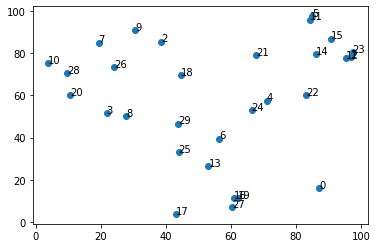

In [17]:
npoints = 30
points = np.round(np.random.random((npoints,2))*100, 2)
distances = distance.pdist(points, 'sqeuclidean').round(2)
sq_matrix_distances = distance.squareform(distances)
plt.scatter(points[:,0], points[:,1])
for i, label in enumerate(points):
    plt.annotate(i, label)


## Disimilarity using distance
We could look into using other distance metrics (*especially* in the high dimensional feature space where euclidean performs poorly).

In [19]:
pointwise_dissimilarity = sq_matrix_distances.mean(axis=0)  # mean distance
# pointwise_dissimilarity = np.sort(sq_matrix_distances, axis=0)[1]  # min distance 
print(f"Mean distance from other points:\n{pointwise_dissimilarity}")
print("Points ordered by most dissimilar: ")
print(points[pointwise_dissimilarity.argsort()[::-1]])

Mean distance from other points:
[4354.52066667 3681.59733333 2591.17333333 2759.813      1812.886
 3958.32066667 1929.249      3590.05966667 2403.06033333 3242.16766667
 4521.46366667 3808.595      3535.10533333 2607.226      2959.739
 3620.966      3811.069      4712.696      1817.00833333 3854.15466667
 3594.566      2146.01766667 2339.401      3808.76266667 1717.90266667
 2339.257      2784.62166667 4250.83333333 3817.884      1846.11933333]
Points ordered by most dissimilar: 
[[43.24  3.81]
 [ 3.91 75.2 ]
 [87.2  16.23]
 [60.33  6.93]
 [84.95 97.56]
 [62.16 11.15]
 [ 9.77 70.62]
 [61.09 11.47]
 [97.47 80.52]
 [84.43 96.  ]
 [97.03 78.36]
 [90.79 86.99]
 [10.64 60.18]
 [19.37 85.08]
 [95.45 77.9 ]
 [30.57 90.82]
 [86.3  79.63]
 [24.1  73.39]
 [21.83 51.48]
 [53.14 26.38]
 [38.63 85.56]
 [27.94 50.26]
 [83.28 60.21]
 [44.   33.3 ]
 [67.85 79.12]
 [56.45 39.56]
 [43.91 46.69]
 [44.63 69.73]
 [71.15 57.58]
 [66.4  52.92]]


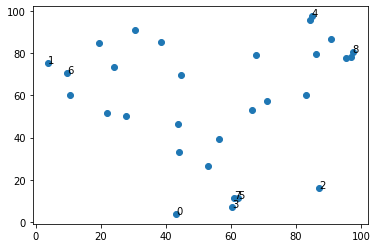

In [20]:
plt.scatter(points[:,0], points[:,1])
for i, label in enumerate (pointwise_dissimilarity.argsort()[:-10:-1]):
    plt.annotate(i, (points[label,0], points[label,1]))

## Clustering

In [21]:
from sklearn import cluster

### CLustering based on point coords (aka features)
Based on the features (in this case just x,y coords) we can cluster the points into groups.
In our case we would be using the 128-dimensional feature vectors (maybe including XYZ somehow, this is where Jan brings in Space2Vec, although I'm not sure its necessary).
From each cluster we could then take the sample with the highest uncertainty?

In [43]:
kmeans = cluster.KMeans(n_clusters=10, random_state=0).fit(points)

Get the most certral point in each cluster

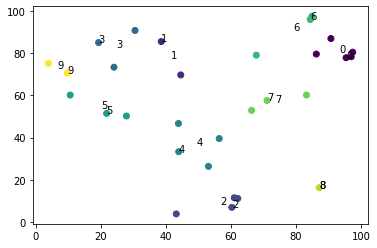

In [44]:
plt.scatter(points[:,0], points[:,1], c=kmeans.labels_)
for i, center in enumerate(kmeans.cluster_centers_):
    # get point closest to the center
    cluster_points = points[np.where(kmeans.labels_ == i)]
    closest_point = cluster_points[np.argmin(distance.cdist(cluster_points, [center], 'euclidean'))]
    plt.annotate(i, center)
    plt.annotate(i, closest_point)

#### Ranking the clusters based on variance
We give each point a random variance in this example.

[0.94 0.46 0.99 0.8  0.06 0.03 0.92 0.61 0.21 0.72 0.88 0.32 0.81 0.13
 0.08 0.13 0.18 0.72 0.81 0.13 0.32 0.18 0.07 0.42 0.07 0.45 0.22 0.4
 0.15 0.61]
Cluster variance:
[0.81 0.99 0.72 0.72 0.92 0.8  0.32 0.07 0.94 0.88]


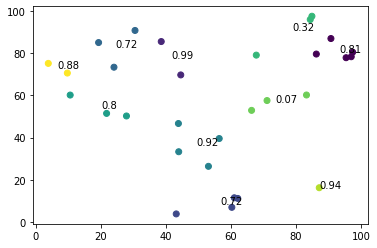

In [59]:
variance = np.random.random(npoints)
print(variance.round(2))
idxs = variance.argsort()[::-1]
plt.scatter(points[:,0], points[:,1], c=kmeans.labels_)


# Get the maximum variance of each cluster
max_cluster_variance = np.zeros(10)
for i in range(10):
    max_cluster_variance[i] = variance[np.where(kmeans.labels_ == i)].max().round(2)
print(f"Cluster variance:\n{max_cluster_variance}")

# Label each cluster with its max_cluster_variance
for i, center in enumerate(kmeans.cluster_centers_):
    # get point closest to the center
    cluster_points = points[np.where(kmeans.labels_ == i)]
    closest_point = cluster_points[np.argmin(distance.cdist(cluster_points, [center], 'euclidean'))]
    plt.annotate(max_cluster_variance[i], center)


## ReDAL
Score each sample with its uncertainty U
Clusters the samples into K clusters based on their feature embeddings
Sort the regions based on the uncertainty U
For each region, penalise the scores of the remaining regions in that cluster by some factor P
The result is a ranking of regions based on uncertainty and diversity (such that the most uncertain regions are ranked first, but repeat regions from the same cluster are unlikely).